<a href="https://colab.research.google.com/github/sstevenson-1966/B9DA100-SS/blob/master/LDA_%26_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import nltk
import re
import numpy as np
import math
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition

# download required nltk packages
# required for tokenization
nltk.download('punkt')
# required for parts of speech tagging
nltk.download('averaged_perceptron_tagger')

### Load Stopwords

stop = set(stopwords.words('english'))
print(len(stop))
print(type(stop))
stop.add('primark')
stop.add('penneys')
stop.add('im')
### stop

pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', None)

num_topics = 20
num_top_words = 10
min_df = .001
max_df = .20
vectoriser_max_features = 200

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
179
<class 'set'>


In [2]:
max_ngram = 0
topic_source = '/content/drive/MyDrive/Colab Data/Topics.xlsx'
#### sourcedata = '/content/drive/MyDrive/Colab Data/MASTERS_TWEETS10.xlsx'
topic_df = pd.read_excel(topic_source)

topic_dict = {}
for index, row in topic_df.iterrows():
  New_Keyword = re.sub(' ', '-', row['Keyword'].lower())
  row['Keyword'] = row['Keyword'].lower()
  if isinstance(row['Alternative'], str) != True:
    row['Alternative'] = row['Keyword']
  else:
    row['Alternative'] = row['Alternative'].lower()
  word_count = len(row['Alternative'].split())
  if word_count > max_ngram:
    max_ngram = word_count
  topic_dict[row['Alternative'].lower()] = New_Keyword
print(topic_dict)
####num_topics = len(topic_dict.keys())
print(num_topics)

{'pjs': 'pyjamas', 'pajamas': 'pyjamas', 'pj': 'pyjamas', 'customer service': 'customer-service', 'ethical': 'ethical', 'store opening': 'store-opening', 'online': 'online', 'zara': 'zara', 'h&m': 'h-and-m', 'socks': 'socks', 'kitchenware': 'kitchenware', 'homewares': 'homewares', 'cosmetics': 'cosmetics', 'beauty': 'beauty', 'health': 'health', 'accessories': 'accessories', 'make-up': 'cosmetics', 'makeup': 'cosmetics', 'carepack': 'carepack', 'care pack': 'carepack', 'care-pack': 'carepack', 'harry potter': 'harrypotter', 'gap': 'gap', 'c&a': 'c-and-a', 'bags/wallets                  ': 'bags/wallets------------------', 'swim & beach                  ': 'swim-&-beach------------------', 'licensed womens               ': 'licensed-womens---------------', 'ladies performancewear        ': 'ladies-performancewear--------', 'mens denim                    ': 'mens-denim--------------------', 'baby basics                   ': 'baby-basics-------------------', 'unassigned d28': 'unassigned-

In [3]:
def plot_top_words(model, feature_names, num_top_words, title):
    fig, axes = plt.subplots(math.ceil(num_topics / 2), 2, figsize=(30, 40), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [27]:
def top_words(topic):
  return topic.argsort()[:-num_top_words -1:-1]

def topic_table(model, feature_names):
  topics = {}
  for topic_idx,topic in enumerate(model.components_):
    t = ("topic_%d:", topic_idx)
    topics[t] = [feature_names[i] for i in top_words(topic)]
  return pd.DataFrame(topics)

In [4]:
### Read Data
sourcedata = '/content/drive/MyDrive/Colab Data/MASTERS_TWEETSEN.xlsx'
#### sourcedata = '/content/drive/MyDrive/Colab Data/MASTERS_TWEETS10.xlsx'
df = pd.read_excel(sourcedata)
df = df[df['screen_name'] != 'Primark']
df = df[df['lang'] == "en"]
df['text'] = df['text'].str.lower()
df['text'].head()

0                                                                                                                                                                                                                                                                                  @primark it’s easily done 😂🙈🙈
1                                                                                                                                                                                                                                                                              @primark would love to do this 😂🙈
2    hey @primark please recognise these 3 amazing women at your oxford street st9re. i've been going through some things recently and had a big anxiety attack and ended up on the floor. they acted quickly made sure i was ok calmed me and helped me massively. please notice them!! https://t.co/b7tfi5hkel
3                                                                                    

In [5]:
print(len(df))
### df['country'].value_counts()



79869


In [6]:
def get_word_frequency(p_column):
  word_frequency = defaultdict(int)

  for text in p_column:
    for word in text.split():
      word_frequency[word] += 1

  print(pd.DataFrame.from_dict(word_frequency, orient='index') \
  .sort_values(0, ascending = False) \
  .rename(columns={0: 'abs_freq'}))

In [7]:
get_word_frequency(df['text'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
def determine_word_types(sentence, word_type):
  nouns = ""
  tokens = nltk.word_tokenize(sentence)
  tagged = nltk.pos_tag(tokens)
  for word, pos in tagged:
    if pos.startswith(word_type):
      nouns = nouns + " " + word
  return nouns.strip()

In [9]:
def check_for_topic(x):
  topic_frequency = defaultdict(int)

  topic_found = ""
  cleaned_text = x
  for key, value in topic_dict.items():
    if key in cleaned_text:
      topic_frequency[value.strip()] += 1
      cleaned_text = re.sub("\\b" + key + "\\b", value, cleaned_text)
    
  topic_found = ""
  for uniq_topic in topic_frequency:
    if len(topic_found) == 0:
      topic_found = uniq_topic
    else:
      topic_found = topic_found + ", " + uniq_topic
  return topic_found, cleaned_text

df['topics'], df['cleantext'] = zip(*df['text'].apply(check_for_topic))

In [10]:
print(df['topics'].value_counts())

                                       69707
online                                  3669
socks                                   1632
pyjamas                                 1316
home                                    1015
zara                                     430
cosmetics                                235
harrypotter                              230
health                                   204
beauty                                   167
ethical                                  152
pyjamas, socks                           124
gap                                      108
online, socks                             77
customer-service                          68
pyjamas, online                           59
accessories                               55
online, home                              48
pyjamas, home                             44
c-and-a                                   41
shopping-bags                             38
xmas-shop                                 38
online, za

In [11]:
def determine_word_types(sentence, word_type):
  nouns = ""
  tokens = nltk.word_tokenize(sentence)
  tagged = nltk.pos_tag(tokens)
  for word, pos in tagged:
    if pos.startswith(word_type):
      nouns = nouns + " " + word
  return nouns.strip()
  

In [12]:
#@title Default title text
lemmatizer = WordNetLemmatizer() 
df = df[~df.text.str.contains("jcpenney")]
df = df[~df.text.str.contains("jc penney")]

def clean_data(x):
    return_line = ""
    x = x.lower()
    unique = []
    for word in x.split():
      if word in unique:
          continue
      unique.append(word)
    ###  print(word)
      if any(chr.isdigit() for chr in word):
        continue
      if word.startswith('http'):
        continue
      if 'primark' in word or any(chr.isdigit() for chr in word):
        continue
      if  word in (stop):
        continue
      if word.startswith('@'):
        continue
      word = re.sub(r'[^\w\s]', '', word)
      if len(word) == 0:
        continue
      if word in (stop):
        continue
      word = lemmatizer.lemmatize(word)
      return_line = return_line + " " + word
    ### print(return_line)
    return_line = determine_word_types(return_line, 'NN')
    ### print(return_line)
    return return_line

df['cleantext'] = df['cleantext'].apply(clean_data)

In [13]:
## df['cleantext'][df['topics'] != None]
df['cleantext'][df['topics'] != ""]
corpus = df['cleantext'][df['topics'] != ""].values
## corpus = df['cleantext'][df.topics.str.contains('potter')]
max_ngram = 10

In [14]:
def cosine_similarity(vector1, vector2):
  vector1 = np.array(vector1)
  vector2 = np.array(vector2)
  return np.dot(vector1, vector2) / np.sqrt(np.sum(vector1**2)) * np.sqrt(np.sum(vector2**2))

In [15]:
tf_vectorizer = TfidfVectorizer(stop_words='english', min_df = min_df, max_df=max_df, ngram_range=(1,max_ngram), max_features=vectoriser_max_features)
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

In [16]:
cv_vectorizer = CountVectorizer(stop_words="english", min_df = min_df, max_df=max_df, ngram_range=(1,max_ngram), max_features=vectoriser_max_features)
cv = cv_vectorizer.fit_transform(corpus)
cv_feature_names = cv_vectorizer.get_feature_names()

  

In [17]:
import operator
def rank_terms(A, terms):
  sums = A.sum(axis = 0)
  weights = {}
  for col, term in enumerate(terms):
    weights[term] = sums[0, col]
  return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

ranking = rank_terms(cv, cv_feature_names)
for i, pair in enumerate(ranking[0:20]):
  print("%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

01. online (1944.00)
02. sock (1738.00)
03. pyjama (1220.00)
04. shop (929.00)
05. home (872.00)
06. store (864.00)
07. people (707.00)
08. shopping (638.00)
09. need (592.00)
10. time (471.00)
11. clothes (436.00)
12. year (407.00)
13. day (362.00)
14. amp (311.00)
15. christmas (311.00)
16. thing (307.00)
17. online shopping (293.00)
18. zara (290.00)
19. dont (269.00)
20. fashion (253.00)


In [18]:
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=15,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(cv)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=15,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

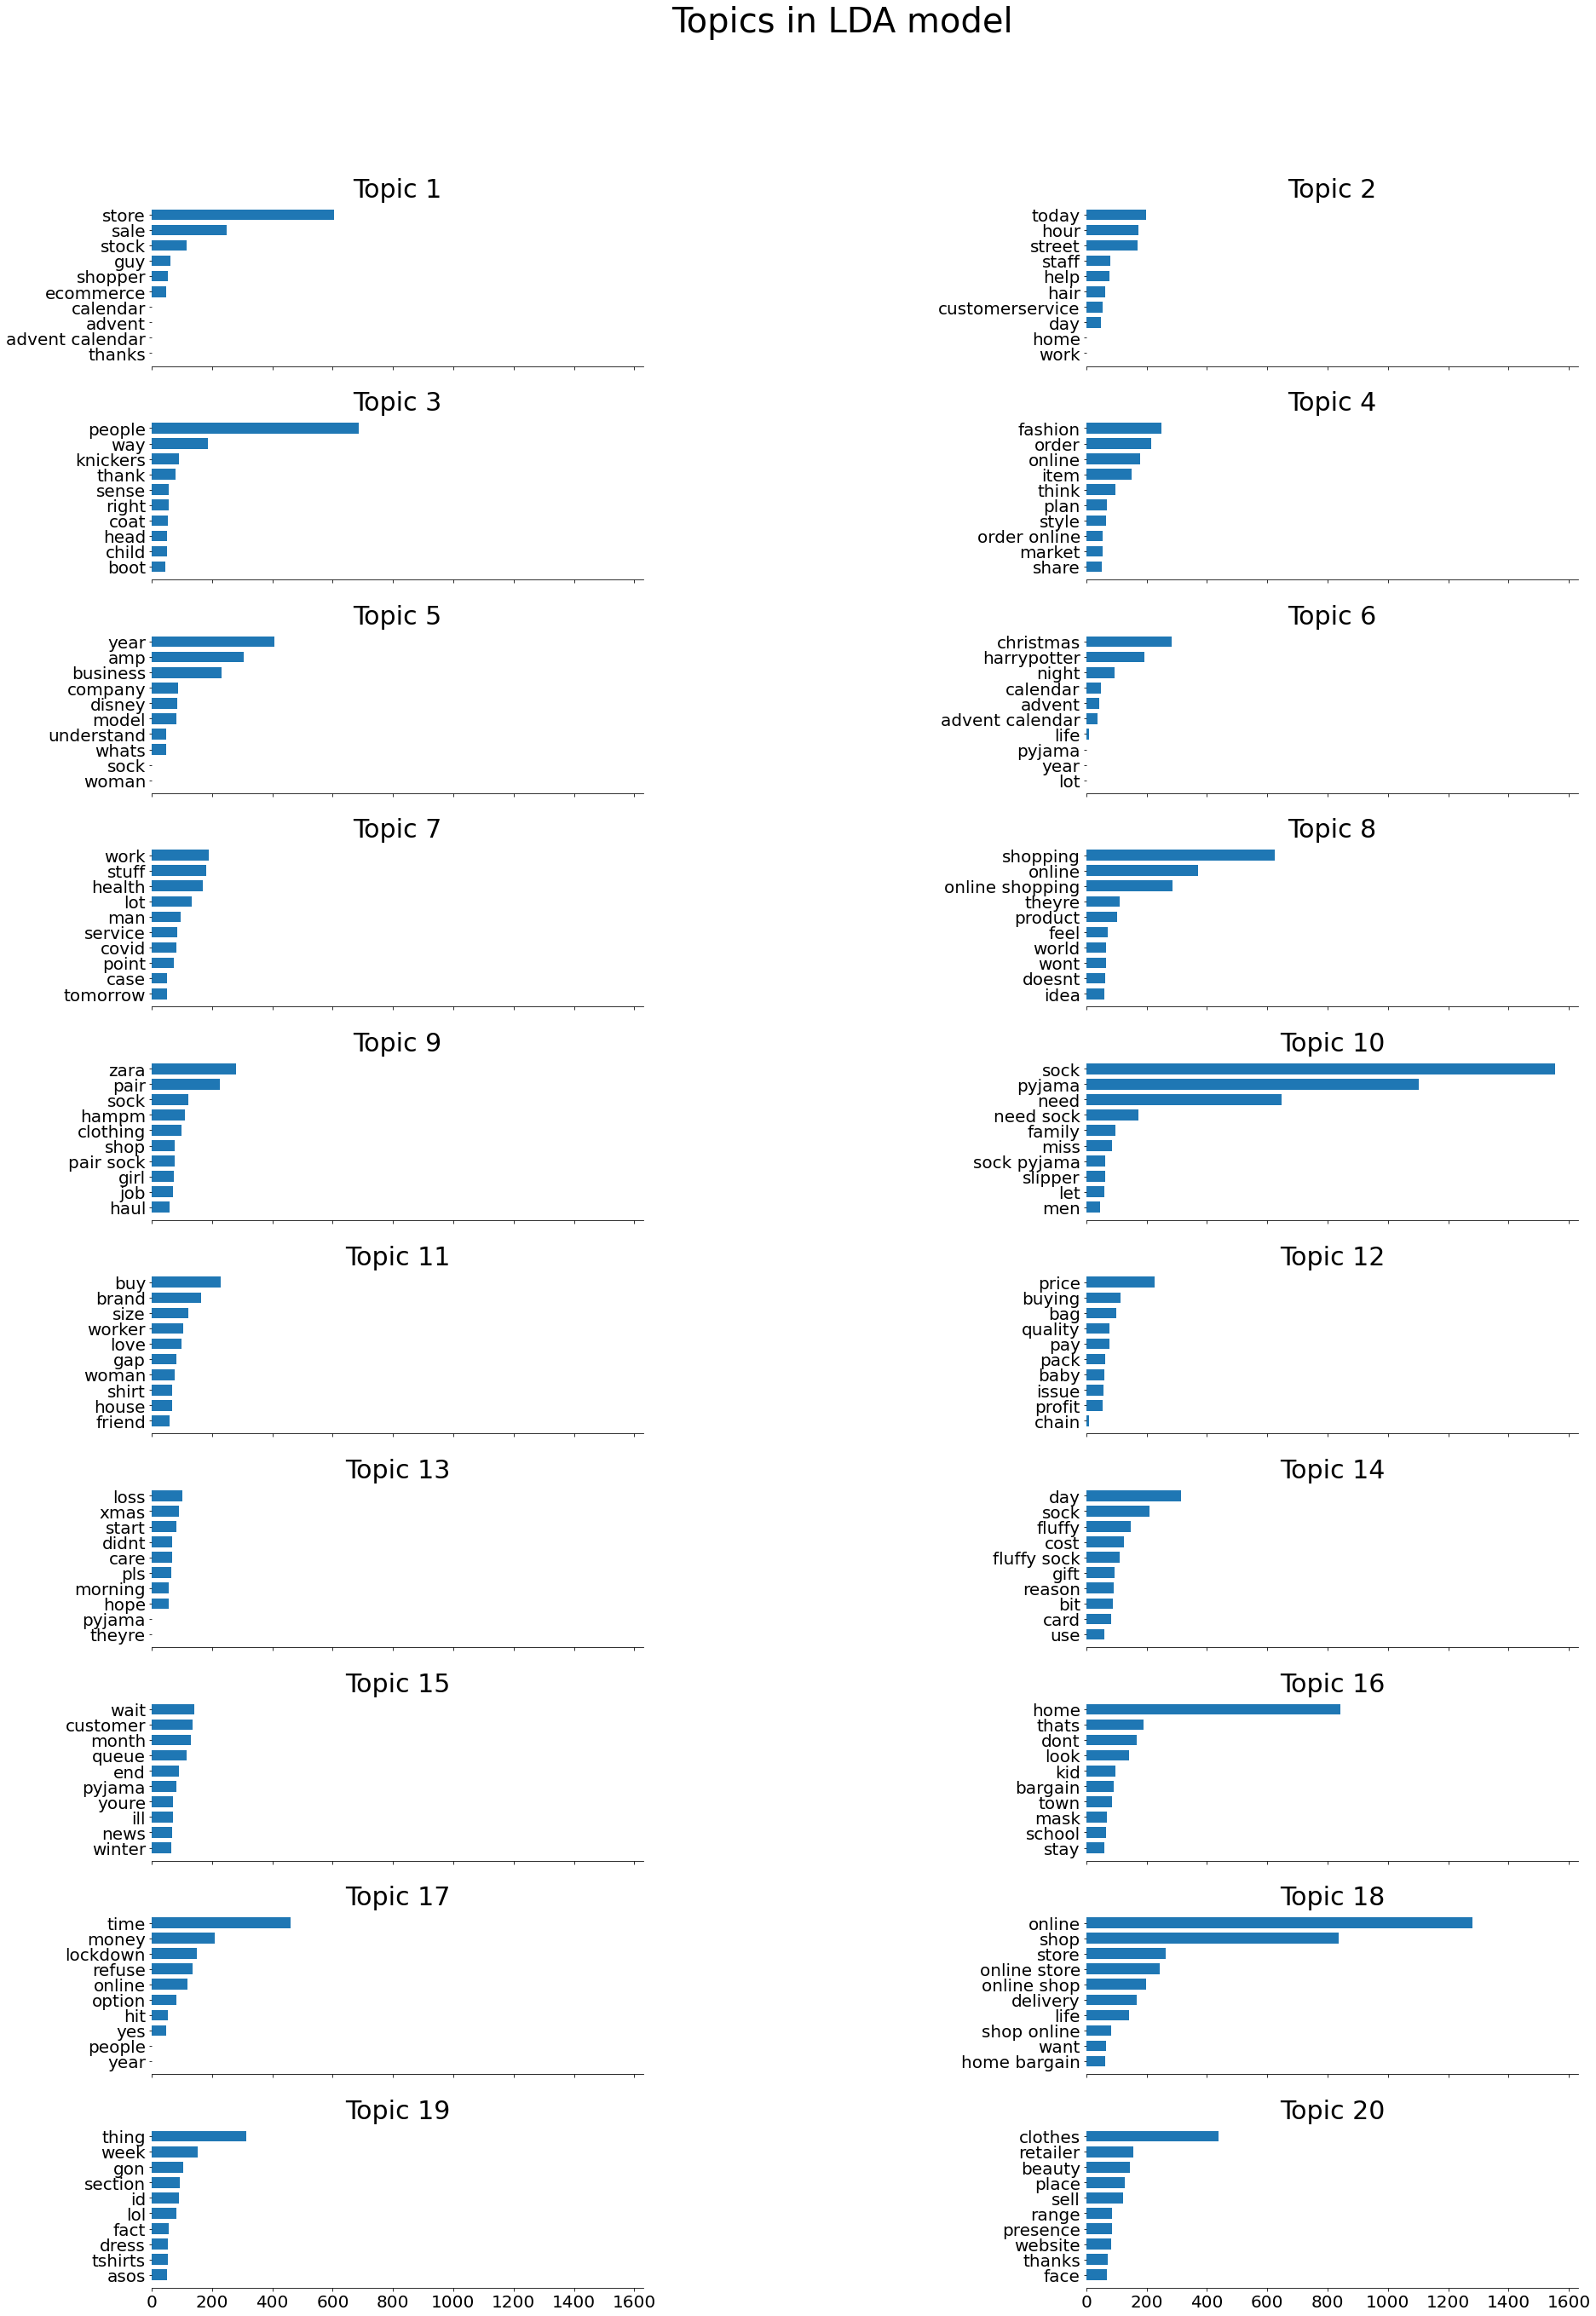

topic_%d:                             ...                                 
                0                1         2   ...            17       18        19
0            store            today    people  ...        online    thing   clothes
1             sale             hour       way  ...          shop     week  retailer
2            stock           street  knickers  ...         store      gon    beauty
3              guy            staff     thank  ...  online store  section     place
4          shopper             help     sense  ...   online shop       id      sell
5        ecommerce             hair     right  ...      delivery      lol     range
6         calendar  customerservice      coat  ...          life     fact  presence
7           advent              day      head  ...   shop online    dress   website
8  advent calendar             home     child  ...          want  tshirts    thanks
9           thanks             work      boot  ...  home bargain     asos      face

[10 rows x 20 columns]

In [28]:
plot_top_words(lda, cv_feature_names, num_top_words, 'Topics in LDA model')
topic_table(lda, cv_feature_names)

In [20]:
clf = decomposition.NMF(n_components = num_topics, init="random", random_state = 0)
W1 = clf.fit_transform(tf)
H1 = clf.components_

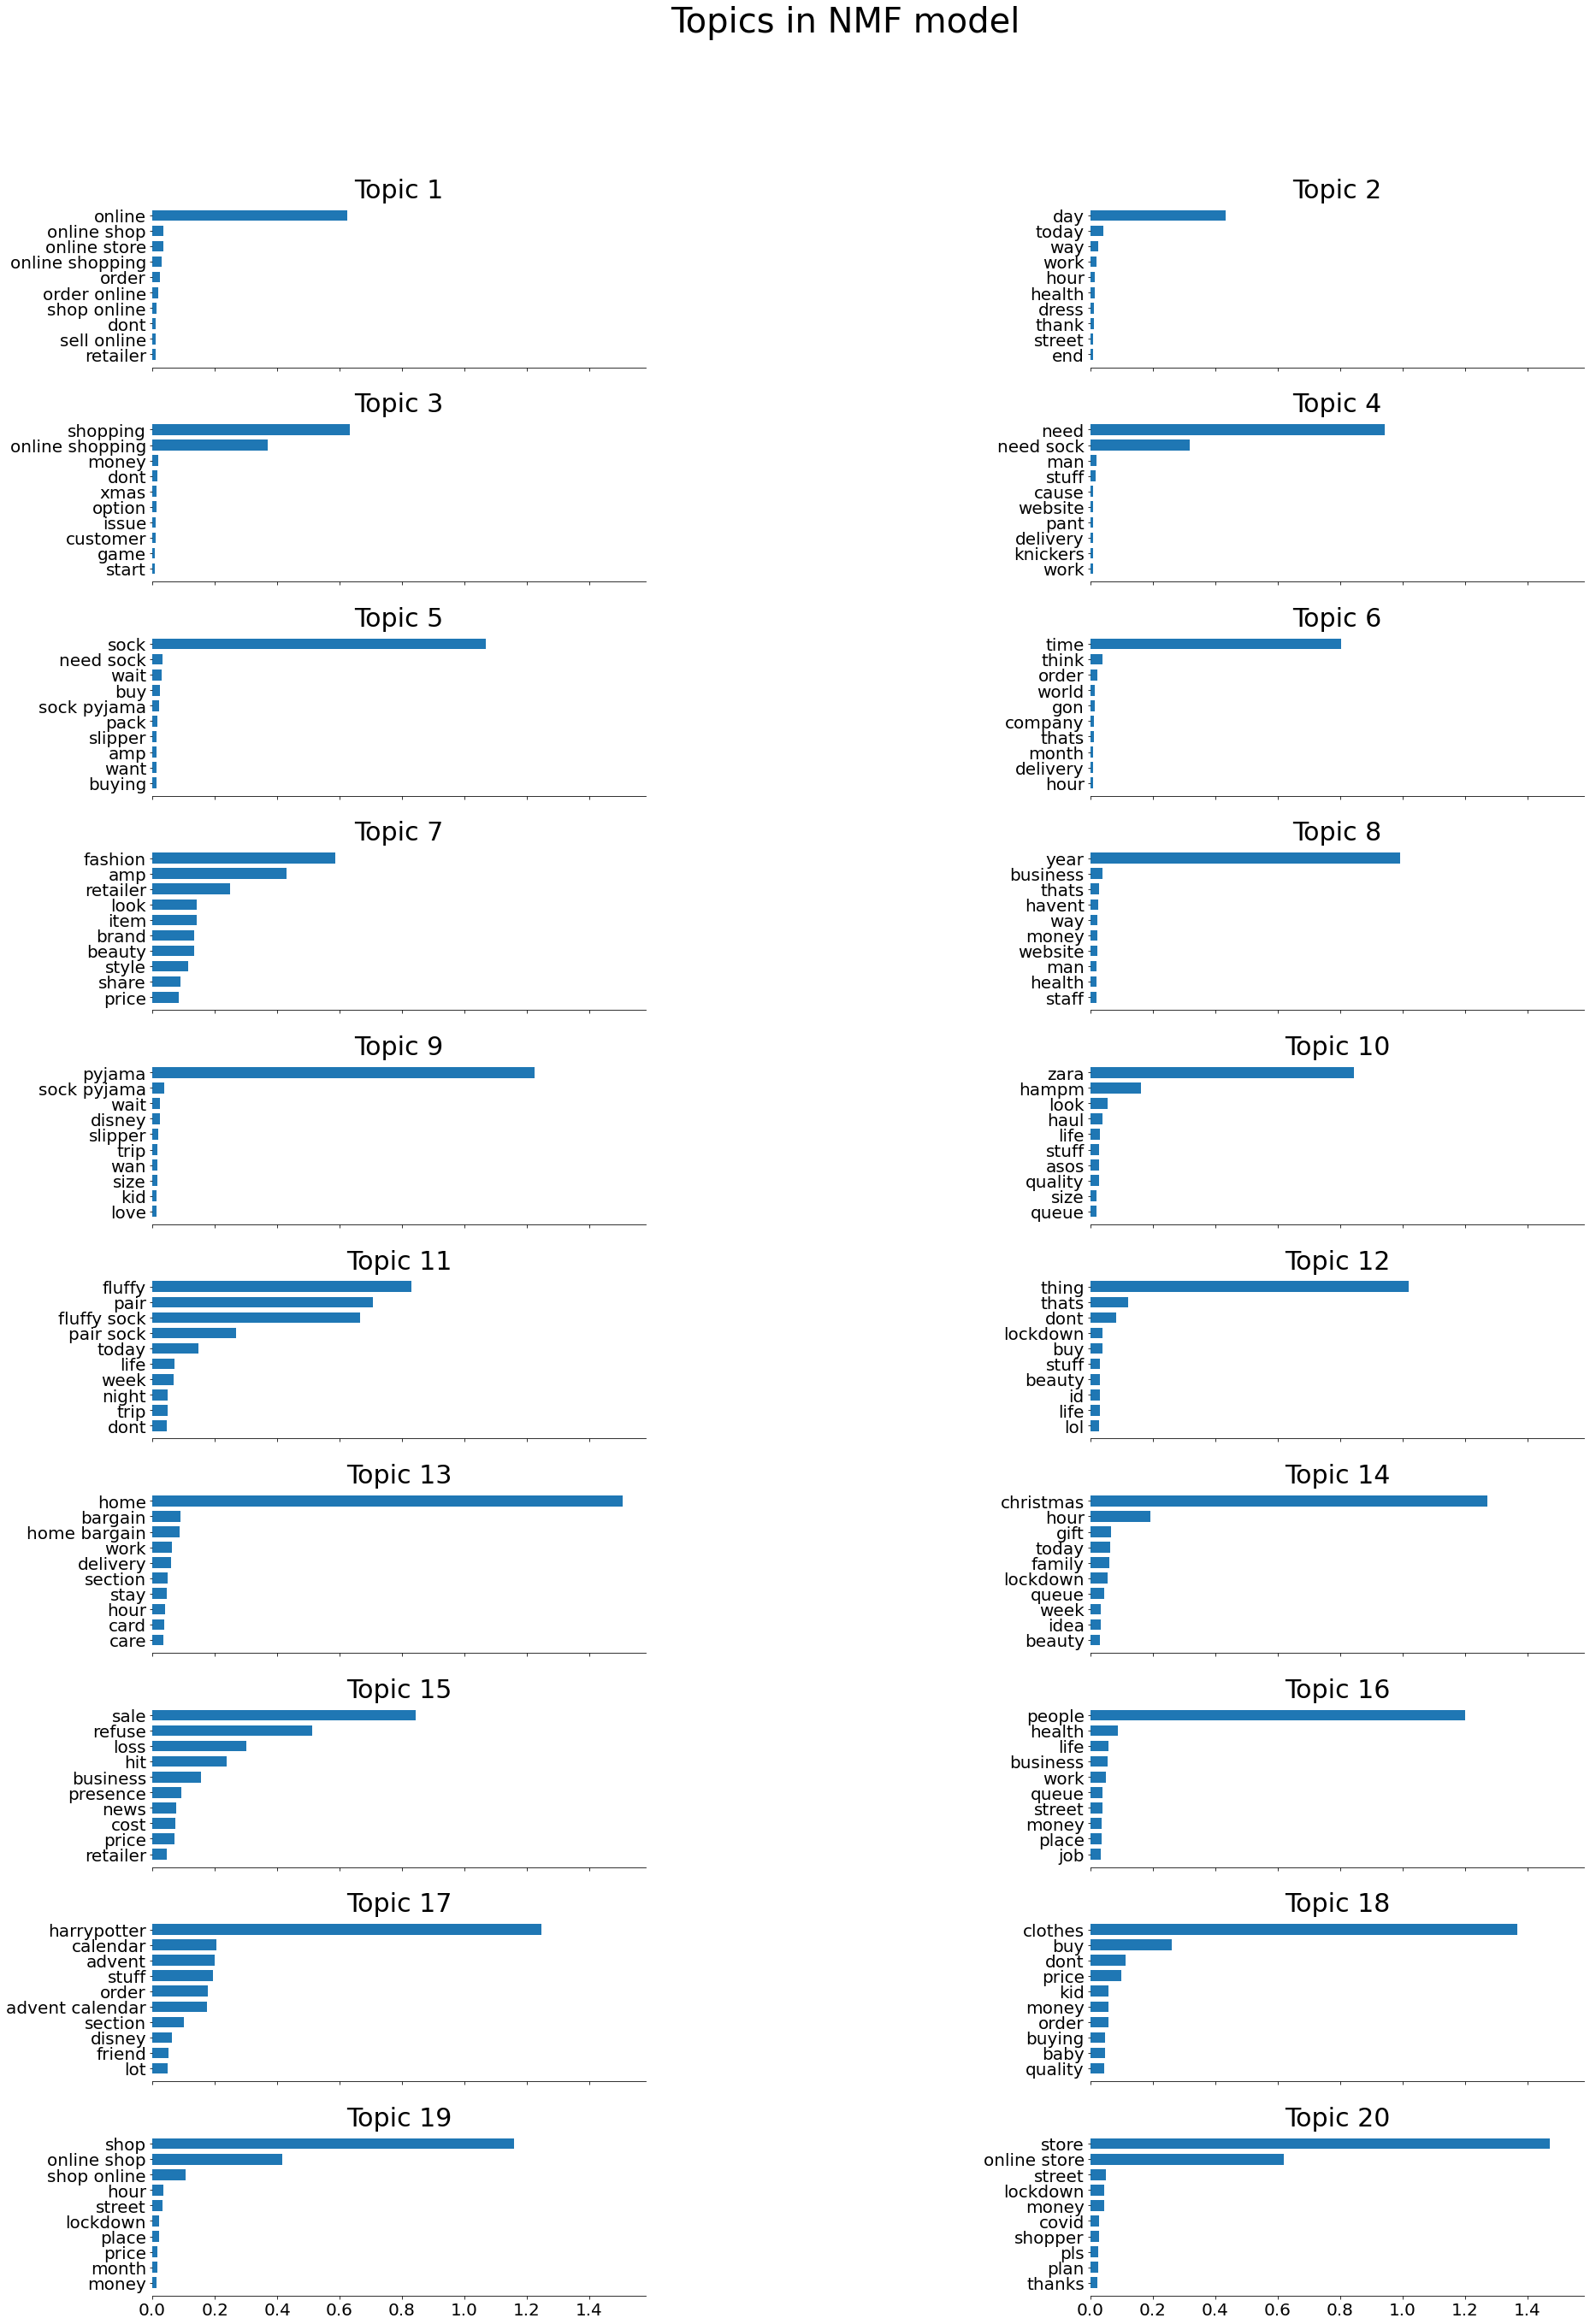

topic_%d:                             ...                                 
                0                1         2   ...            17       18        19
0            store            today    people  ...        online    thing   clothes
1             sale             hour       way  ...          shop     week  retailer
2            stock           street  knickers  ...         store      gon    beauty
3              guy            staff     thank  ...  online store  section     place
4          shopper             help     sense  ...   online shop       id      sell
5        ecommerce             hair     right  ...      delivery      lol     range
6         calendar  customerservice      coat  ...          life     fact  presence
7           advent              day      head  ...   shop online    dress   website
8  advent calendar             home     child  ...          want  tshirts    thanks
9           thanks             work      boot  ...  home bargain     asos      face

[10 rows x 20 columns]

In [26]:
plot_top_words(clf, tf_feature_names, num_top_words, 'Topics in NMF model')
topic_table(clf, tf_feature_names)


In [ ]:
### Each row represents a topic and each column a term
print("TF - Num. of documents, Num. of terms   = " + str(tf.shape[0]) + ", " + str(tf.shape[1]))
print("TF_FEATURE_NAMES - Num. of terms        = " + str(len(tf_feature_names)))
print("H1 - Num. of topics, Num. of terms      = " + str(H1.shape[0]) + ", " + str(H1.shape[1]))
print("W1 = Num. of documents, Num. of topics  = " + str(W1.shape[0]) + ", " + str(W1.shape[1]))
print("Corpus length                         = " + str(len(corpus)))
print("")


words = np.array(tf_feature_names)
for i in range(0, H1.shape[0]):
 print(words[np.argsort(H1[i])[-10:]])


TF - Num. of documents, Num. of terms   = 10150, 200
TF_FEATURE_NAMES - Num. of terms        = 200
H1 - Num. of topics, Num. of terms      = 20, 200
W1 = Num. of documents, Num. of topics  = 10150, 20
Corpus length                         = 10150

['retailer' 'sell online' 'dont' 'shop online' 'order online' 'order'
 'online shopping' 'online store' 'online shop' 'online']
['end' 'street' 'thank' 'dress' 'health' 'hour' 'work' 'way' 'today' 'day']
['start' 'game' 'customer' 'issue' 'option' 'xmas' 'dont' 'money'
 'online shopping' 'shopping']
['work' 'knickers' 'delivery' 'pant' 'website' 'cause' 'stuff' 'man'
 'need sock' 'need']
['buying' 'want' 'amp' 'slipper' 'pack' 'sock pyjama' 'buy' 'wait'
 'need sock' 'sock']
['hour' 'delivery' 'month' 'thats' 'company' 'gon' 'world' 'order' 'think'
 'time']
['price' 'share' 'style' 'beauty' 'brand' 'item' 'look' 'retailer' 'amp'
 'fashion']
['staff' 'health' 'man' 'website' 'money' 'way' 'havent' 'thats'
 'business' 'year']
['love' 'kid' 'size

In [ ]:
import itertools

def using_tocoo(x):
  cx = x.tocoo()
  for i,j,v in zip(cx.row, cx.col, cx.data):
    print(tf_feature_names[j])

using_tocoo(tf[0,:])

harrypotter
harrypotter section
head
section
thing


In [ ]:
W1.shape

(266, 20)

In [ ]:
tf.shape

(266, 1000)

In [ ]:
vocab = np.array(tf_feature_names)
vocab

array(['able', 'actually', 'ad', 'advent', 'advent calendar',
       'advent calendar got', 'advent calendar got hyped',
       'advent calendar got hyped christmas', 'advent calendar sale',
       'advent calendar sale soon', 'advent calendar stock',
       'advent calendar thewizardingworld',
       'advent calendar thewizardingworld harrypotterforum',
       'advent calendar thewizardingworld harrypotterforum fan',
       'advent calendar thewizardingworld harrypotterforum fan harrypottercalendar',
       'advent calendar thewizardingworld harrypotterforum fan harrypottercalendar calendar',
       'advent calendar thewizardingworld harrypotterforum fan harrypottercalendar calendar hogwarts',
       'advent calendar thewizardingworld harrypotterforum fan harrypottercalendar calendar hogwarts harrypotter',
       'advent calendar thewizardingworld harrypotterforum fan harrypottercalendar calendar hogwarts harrypotter wizardingworld',
       'advent calender', 'adventcalendar', 'age', 

In [ ]:
top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [', '.join(t) for t in topic_words]

In [ ]:
topics

['advent calendar, calendar, advent, harrypotter advent calendar, harrypotter advent, store, stock, harrypotter advent calendar stock, advent calendar stock, calendar stock',
 'sock, harrypotter sock, want harrypotter, want harrypotter sock, december, bring, stock harrypotter, best, woman, getting harrypotter',
 'merch, harrypotter merch, shop, way, buy, say, buy harrypotter merch, taking, buy harrypotter, buying harrypotter',
 'stuff, harrypotter stuff, going, need harrypotter stuff, need harrypotter, anymore, need, run, waiting, stuff harrypotter',
 'harrypotter advent calendar got, advent calendar got, calendar got, got, got hyped, harrypotter advent calendar got hyped christmas, calendar got hyped christmas, calendar got hyped, advent calendar got hyped christmas, hyped',
 'section, harrypotter section, harrypotter section birmingham, section birmingham, birmingham, sad, work, miss, really, walking',
 'pyjama, harrypotter pyjama, fluffy, tell, great, girl, thong, thong harrypotter,

In [ ]:
corpus

5         never read watched anything harrypotter would even run section nah mum anti thing drilled head demonic                                                                                               
447       new selling harrypotter themed advent calendar online could get link                                                                                                                                 
588       harrypotter advent calendar got everyone hyped christmas                                                                                                                                             
591       harrypotter advent calendar got everyone hyped christmas                                                                                                                                             
594       harrypotter advent calendar got everyone hyped christmas                                                                                                      

In [ ]:
colnames = ["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(corpus))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic


In [ ]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.00,0.00,0.00,0.02,0.00,0.17,0.00,0.00,0.00,0.01,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10
Doc1,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,14
Doc2,0.01,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
Doc3,0.01,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
Doc4,0.01,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
Doc5,0.01,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
Doc6,0.01,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
Doc7,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.04,0.01,0.00,0.06,0.01,0.00,0.00,0.00,0.00,0.00,1
Doc8,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.03,0
Doc9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,19


In [ ]:
print(tf_vectorizer.vocabulary_)

{'read': 819, 'run': 831, 'section': 841, 'mum': 365, 'thing': 917, 'head': 232, 'new': 375, 'selling': 844, 'themed': 905, 'advent': 3, 'calendar': 63, 'online': 392, 'link': 284, 'selling harrypotter': 845, 'harrypotter themed': 212, 'advent calendar': 4, 'got': 158, 'hyped': 256, 'christmas': 94, 'harrypotter advent': 171, 'calendar got': 64, 'got hyped': 159, 'hyped christmas': 257, 'harrypotter advent calendar': 172, 'advent calendar got': 5, 'calendar got hyped': 65, 'got hyped christmas': 160, 'harrypotter advent calendar got': 173, 'advent calendar got hyped': 6, 'calendar got hyped christmas': 66, 'harrypotter advent calendar got hyped': 174, 'advent calendar got hyped christmas': 7, 'harrypotter advent calendar got hyped christmas': 175, 'disney': 125, 'amp': 23, 'sock': 867, 'woman': 971, 'amp harrypotter': 24, 'harrypotter sock': 210, 'calender': 85, 'sold': 868, 'ebay': 131, 'price': 698, 'hour': 252, 'advent calender': 19, 'price hour': 708, 'harrypotter advent calender':

In [ ]:
print(cv_vectorizer.vocabulary_)

{'read': 819, 'run': 831, 'section': 841, 'mum': 365, 'thing': 917, 'head': 232, 'new': 375, 'selling': 844, 'themed': 905, 'advent': 3, 'calendar': 63, 'online': 392, 'link': 284, 'selling harrypotter': 845, 'harrypotter themed': 212, 'advent calendar': 4, 'got': 158, 'hyped': 256, 'christmas': 94, 'harrypotter advent': 171, 'calendar got': 64, 'got hyped': 159, 'hyped christmas': 257, 'harrypotter advent calendar': 172, 'advent calendar got': 5, 'calendar got hyped': 65, 'got hyped christmas': 160, 'harrypotter advent calendar got': 173, 'advent calendar got hyped': 6, 'calendar got hyped christmas': 66, 'harrypotter advent calendar got hyped': 174, 'advent calendar got hyped christmas': 7, 'harrypotter advent calendar got hyped christmas': 175, 'disney': 125, 'amp': 23, 'sock': 867, 'woman': 971, 'amp harrypotter': 24, 'harrypotter sock': 210, 'calender': 85, 'sold': 868, 'ebay': 131, 'price': 698, 'hour': 252, 'advent calender': 19, 'price hour': 708, 'harrypotter advent calender':

In [ ]:
tf_matrix = tf_vectorizer.transform(corpus).toarray()
print(len(tf_matrix))

266


In [ ]:
J

NameError: ignored